# Prediction of phishing webpages 

This file contains codes which builds a binary classification model to distinguish phishing from legitimate webpages. Here, the features are evaluated using a number of ML algorithms to identify the best performing features, the best performing algorithm and the optimal prediction performance. In this notebook, the following tasks are performed;
1. Importing of libraries and data file
2. Data profiling
3. Data cleaning and EDA
5. Feature correlation analysis
6. Feature encoding
7. Feature selection
8. Model evaluation
9. ROC analysis
10. Hyperparameter tuning


## Importing Libraries and Data

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import category_encoders as ce
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold  # a CV with folds where each one contains the same ratio of classes as in general dataset
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict  # for generating confusion matrix with CV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier,XGBRFClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import shap
import warnings

warnings.filterwarnings("ignore")

#file = 'C:/Users/tomna/OneDrive/Datasets/Model 1 Rework/Dataset - Phase 2/Combined/Dataset_Final.csv'
file = 'C:/Users/44744/Desktop/Notebooks/Dataset_Final.csv'
df = pd.read_csv(file)

## Data Profiling

In [140]:
df.head()

,DomainIdentityInPage,DomainIdentityInCopyright,DomainIdentityInCanonical,DomainIdentityInAlternate,ForeignHyperlinks,VoidHyperlinkRatio,ForeignFormHandler,IPInURL,NumericFQDN,NumericPath,...,FHDomainValidity,FHDomainAge,SSLCertificateType,SSLGeoCountryMatch,URLSearchEngineRanking,DomainSearchEngineRanking,FQDNSearchEngineRanking,FQDNBlacklistIPCounts,DomainBlacklistIPCounts,Class
0,10,Null,Null,Null,Yes,0.00,Internal,No,1,0,...,Yes,8832,OV,No,Yes,Yes,Yes,0,0,Legitimate
1,13,No,Yes,Null,Yes,0.00,Internal,No,0,0,...,Yes,4984,OV,Yes,Yes,Yes,Yes,0,0,Legitimate
2,1,No,Yes,Null,Yes,0.12,Internal,No,0,0,...,Yes,1909,OV,Yes,Yes,Yes,Yes,0,0,Legitimate
3,111,Yes,Yes,Yes,Yes,0.07,Internal,No,0,1,...,Yes,8334,OV,Yes,No,Yes,Yes,0,0,Legitimate
4,103,Yes,Yes,Yes,Yes,0.03,Internal,No,0,1,...,Yes,8334,OV,Yes,No,Yes,Yes,0,0,Legitimate


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26114 entries, 0 to 26113
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DomainIdentityInPage       26114 non-null  int64  
 1   DomainIdentityInCopyright  26114 non-null  object 
 2   DomainIdentityInCanonical  26114 non-null  object 
 3   DomainIdentityInAlternate  26114 non-null  object 
 4   ForeignHyperlinks          26114 non-null  object 
 5   VoidHyperlinkRatio         26114 non-null  float64
 6   ForeignFormHandler         26114 non-null  object 
 7   IPInURL                    26114 non-null  object 
 8   NumericFQDN                26114 non-null  int64  
 9   NumericPath                26114 non-null  int64  
 10  DomainEncoding             26114 non-null  object 
 11  PathEncodedCharacters      26114 non-null  int64  
 12  RedirectionalChar          26114 non-null  object 
 13  OutPositionedDomain        26114 non-null  obj

In [142]:
df.shape

(26114, 36)

There are 36 columns, 35 are the features and the last column 'Class' is a target. 16 features are numerical, 19 are non-numerical.
Total number of rows is 26,114.

In [143]:
# display statistical measures of all numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DomainIdentityInPage,26114.0,34.355442,205.040612,0.0,0.00,2.00,23.00,12647.0
VoidHyperlinkRatio,26114.0,0.135339,0.299717,-1.0,0.00,0.02,0.18,1.0
NumericFQDN,26114.0,0.406793,1.828951,0.0,0.00,0.00,0.00,42.0
NumericPath,26114.0,9.242360,22.805115,0.0,0.00,0.00,4.00,333.0
PathEncodedCharacters,26114.0,0.338324,2.172949,0.0,0.00,0.00,0.00,58.0
NoDotsFQDN,26114.0,1.850387,0.702378,1.0,1.00,2.00,2.00,18.0
NoDotsPath,26114.0,0.996898,2.107031,0.0,0.00,0.00,1.00,36.0
ObfuscationCharFQDN,26114.0,0.148656,0.499642,0.0,0.00,0.00,0.00,7.0
ObfuscationCharPath,26114.0,1.604235,3.399552,0.0,0.00,0.00,2.00,65.0
NoOfSlash,26114.0,4.658076,1.790805,2.0,3.00,4.00,5.00,35.0


<AxesSubplot:xlabel='Class', ylabel='count'>

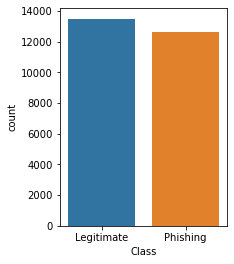

In [144]:
# checking distribution of samples per class. It can be observed that the binary classes are nearly balanced.
#df['Class'].value_counts()
plt.figure(figsize=(3,4))
sns.countplot(data=df, x='Class')

## Data Cleaning and EDA

Identifying missing values represented with other values other than NaN and converting them to the latter

In [145]:
# first, we identify numerical and non-numerical columns
cols = df.columns.to_list()
numerical_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()

In [146]:
# identify unique value of each categorical feature
print('Unique values in each categorical column:')
for col in categorical_cols :
        print(col, '\n', df[col].unique())

Unique values in each categorical column:
DomainIdentityInCopyright 
 ['Null' 'No' 'Yes']
DomainIdentityInCanonical 
 ['Null' 'Yes' 'No' 'Void']
DomainIdentityInAlternate 
 ['Null' 'Yes' 'No' 'Void']
ForeignHyperlinks 
 ['Yes' 'No']
ForeignFormHandler 
 ['Internal' 'External']
IPInURL 
 ['No' 'Yes']
DomainEncoding 
 ['No']
RedirectionalChar 
 ['No' 'Yes']
OutPositionedDomain 
 ['No' 'Yes']
NonStandardPort 
 ['Null' 'Yes' 'No']
ShortURL 
 ['No' 'Yes']
SubdomainService 
 ['No' 'Yes']
DomainNameValidity 
 ['Yes' 'Unknown' 'No']
FHDomainValidity 
 ['Yes' 'Unknown' 'No']
SSLCertificateType 
 ['OV' 'DV' 'EV' 'Null' nan]
SSLGeoCountryMatch 
 ['No' 'Yes' 'Unknown']
URLSearchEngineRanking 
 ['Yes' 'No']
DomainSearchEngineRanking 
 ['Yes' 'No']
FQDNSearchEngineRanking 
 ['Yes' 'No']
Class 
 ['Legitimate' 'Phishing']


In [147]:
# replacing Null, Void and Unknown values observed above with NaN
df.replace(['Null','Void','Unknown'], np.nan, inplace=True)

In [148]:
# Identifying values that are below 0 in each numerical feature to spot potential errors
for col in numerical_cols :
    list_unique_value_col = df[col].unique()
    sublist_unique_value_col = [x for x in list_unique_value_col if x < 0]    # get values less than 0
    if sublist_unique_value_col:
        print(col, '-', sorted(sublist_unique_value_col, reverse=True)) 

VoidHyperlinkRatio - [-1.0]
DomainAge - [-1, -8]
FHDomainAge - [-1, -8]


Negative values in the three features above are meaningless, thus treated as errors/missing values. We therefore replace them with NaN

In [149]:
df.replace([-1.0,-1,-8], np.nan, inplace=True)

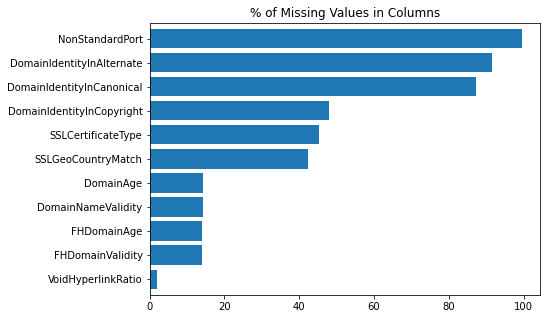

In [150]:
# plotting percentages of missing values for features with at least one missing value
df_null_cols = round((df.isnull().sum()/df.shape[0]*100), 1).sort_values(ascending=True) 
df_null_cols[df_null_cols > 0.0].plot.barh(figsize=(7,5), title='% of Missing Values in Columns', width=0.8)   # plot % of missing values by columns
plt.show()

In [151]:
# dropping all columns with at least 50% missing values
df_null_cols_del = df_null_cols[df_null_cols > 50.0]
cols_del = df_null_cols_del.index.to_list()   # return a list of columns to be deleted
df.drop(cols_del, axis = 1, inplace = True)  
print('Dropped features: ', cols_del)

Dropped features:  ['DomainIdentityInCanonical', 'DomainIdentityInAlternate', 'NonStandardPort']


In [152]:
# Replacing missing values in all columns with imputed values
    # first, we update the list of columns after deleting some of them in the previous step
numerical_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
    # imputing the numerical columns with a median value for each column
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(df[numerical_cols])
df[numerical_cols] = imputer.transform(df[numerical_cols])
    # imputing the categorical columns with a fixed value
imputer = SimpleImputer(strategy='constant', missing_values=np.nan, fill_value='Unknown')
imputer = imputer.fit(df[categorical_cols])
df[categorical_cols] = imputer.transform(df[categorical_cols])
print('Missing values in the new dataset:')
df.isnull().sum()

Missing values in the new dataset:


DomainIdentityInPage         0
DomainIdentityInCopyright    0
ForeignHyperlinks            0
VoidHyperlinkRatio           0
ForeignFormHandler           0
IPInURL                      0
NumericFQDN                  0
NumericPath                  0
DomainEncoding               0
PathEncodedCharacters        0
RedirectionalChar            0
OutPositionedDomain          0
NoDotsFQDN                   0
NoDotsPath                   0
ObfuscationCharFQDN          0
ObfuscationCharPath          0
NoOfSlash                    0
NoOfCharFQDN                 0
NoOfCharPath                 0
ShortURL                     0
SubdomainService             0
DomainNameValidity           0
DomainAge                    0
FHDomainValidity             0
FHDomainAge                  0
SSLCertificateType           0
SSLGeoCountryMatch           0
URLSearchEngineRanking       0
DomainSearchEngineRanking    0
FQDNSearchEngineRanking      0
FQDNBlacklistIPCounts        0
DomainBlacklistIPCounts      0
Class   

In [153]:
# checking and removing duplicated records
original_rows = df.shape[0]
df.drop_duplicates(keep='first', inplace=True)
new_rows = df.shape[0]
print('Deleted number of duplicated rows: ', original_rows - new_rows)

Deleted number of duplicated rows:  720


In [154]:
# identifying and removing irrelevant columns i.e those with zero variance (which have only one unique value)
cols = df.columns.to_list()
# get fractions (%) of unique values for each column sorted by the largest
# if the fraction is 1, this means the column has only one unique value thus irrelevant for prediction
print('Irrelevant column(s) dropped: ')
for col in cols :
    counts_unique_values = round(df[col].value_counts(sort=True, normalize=True),3)  # normalize creates a fraction of couts of each unique value in each column
    if counts_unique_values.iloc[0] == 1.0 :
        print(col)
        df.drop([col], axis = 1, inplace=True)  # drop column with one unique value only

Irrelevant column(s) dropped: 
DomainEncoding


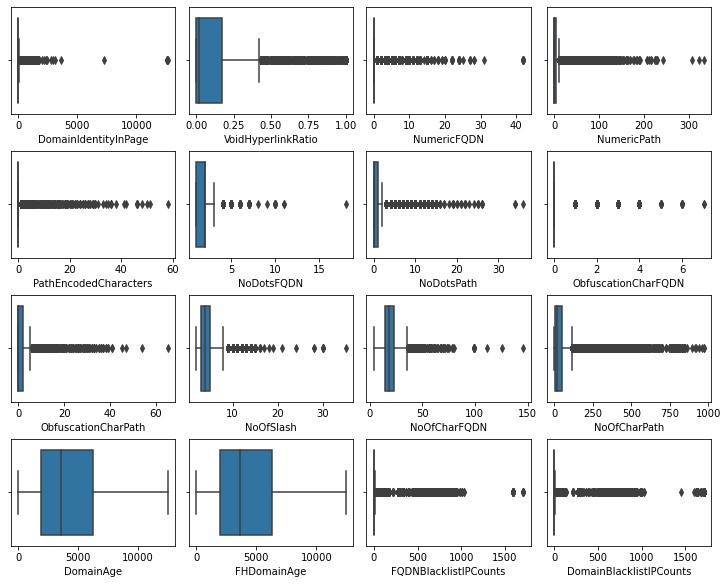

In [155]:
# identifying outliers in continous columns
# first we update the columns after deletion in previous steps
numerical_cols = df.select_dtypes(include='number').columns.to_list()
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()

# plotting box plots to observe the outliers
fig,axes = plt.subplots(4,4, figsize=(10,8), constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
axes = axes.flatten()
for col in numerical_cols :
    sns.boxplot(df[col], ax=axes[numerical_cols.index(col)])

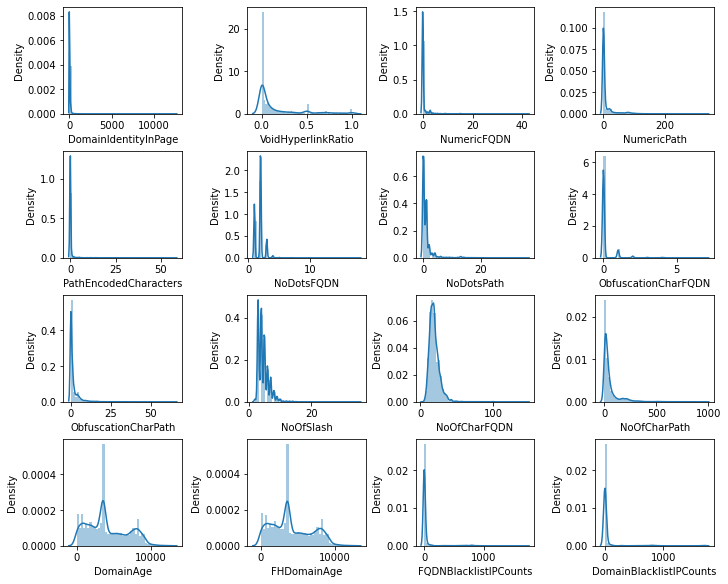

In [156]:
# another observation of outliers and data distribution using histogram and kde plots
fig,axes = plt.subplots(4,4, figsize=(10,8), constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
axes = axes.flatten()
for col in numerical_cols :
    sns.distplot(df[col], ax=axes[numerical_cols.index(col)])

There are potential outliers in most columns. However, based on our knowledge on the domain and the data collection method used, we confirmed that the values are true real world scenarios and not errors. Therefore, we leave the values untreated as they are because they convey a significant information.

## More EDA and Feature Correlation Analysis
Here, we analyze relationships of features of the cleaned dataset using various graphical plots. We use a pairplot to understand relationships between numerical features, and bar and box plots to analyze data distributions of categorical and numerical features respectively

<Figure size 3600x3600 with 0 Axes>

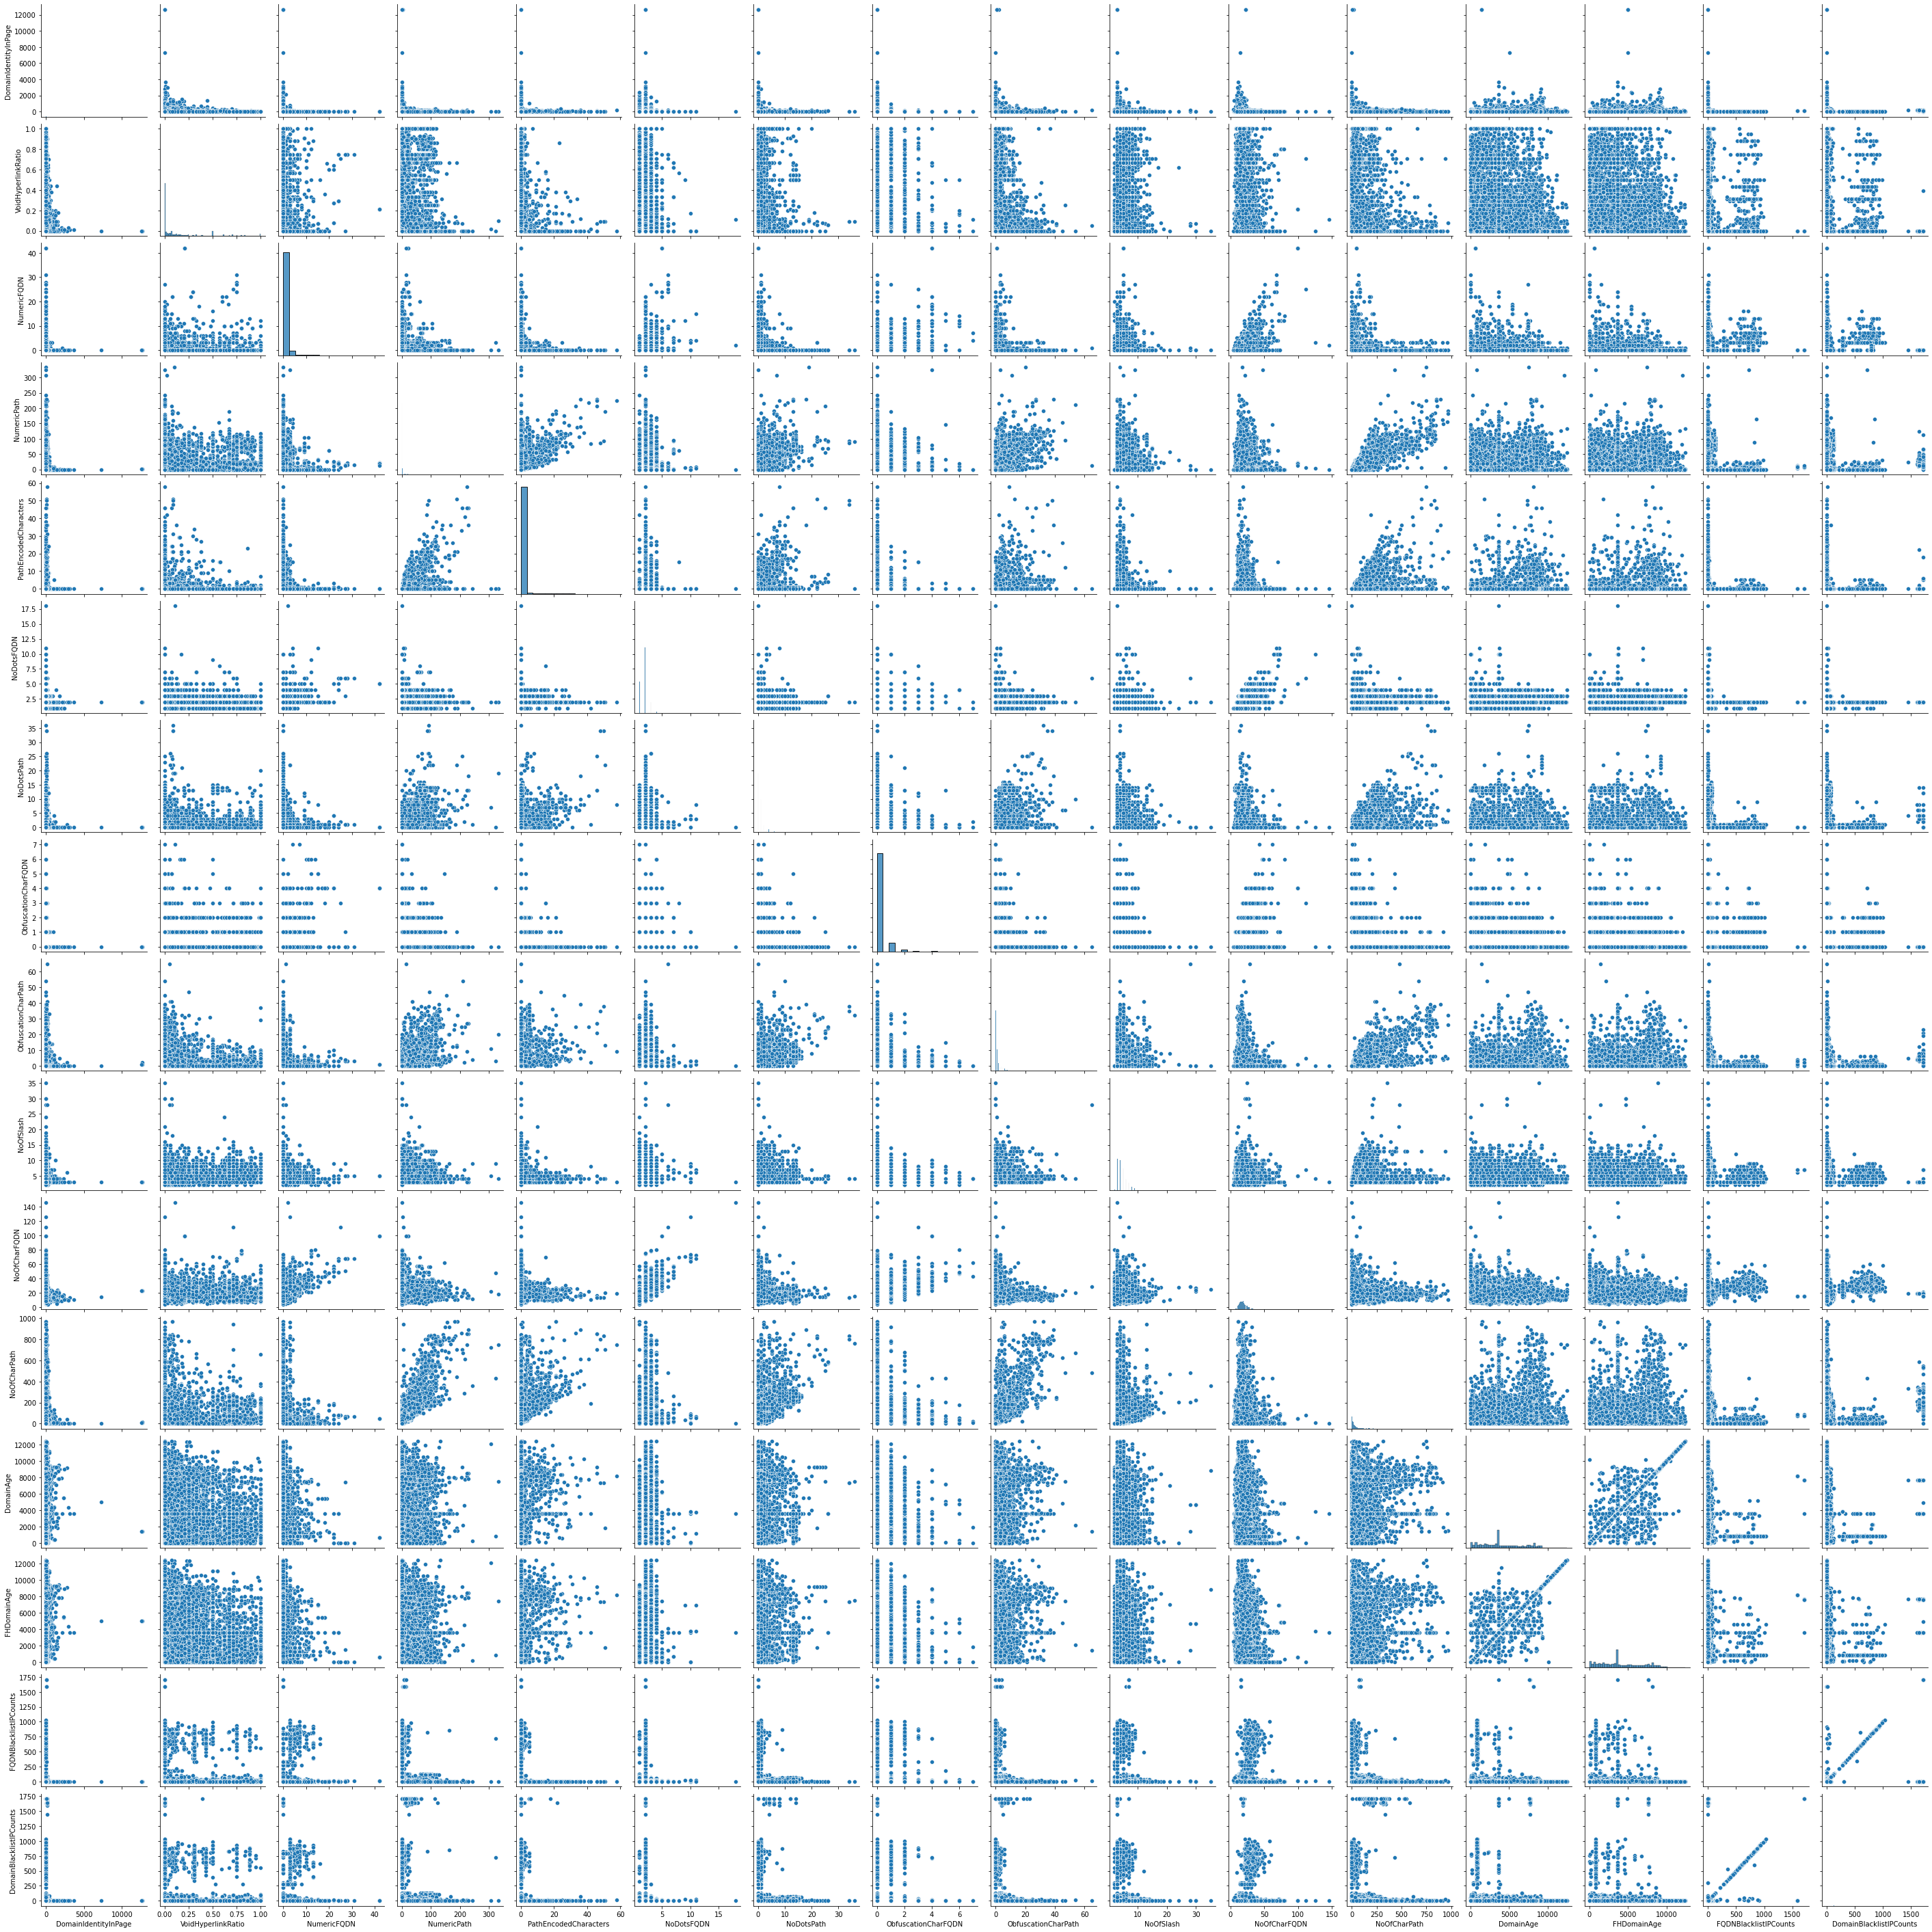

In [157]:
# plotting pair plots of numerical features to observe relationships between them
plt.figure(figsize=(50,50))
plt.suptitle('Pair Plots of Numerical Features')
sns.pairplot(df) 
plt.show()

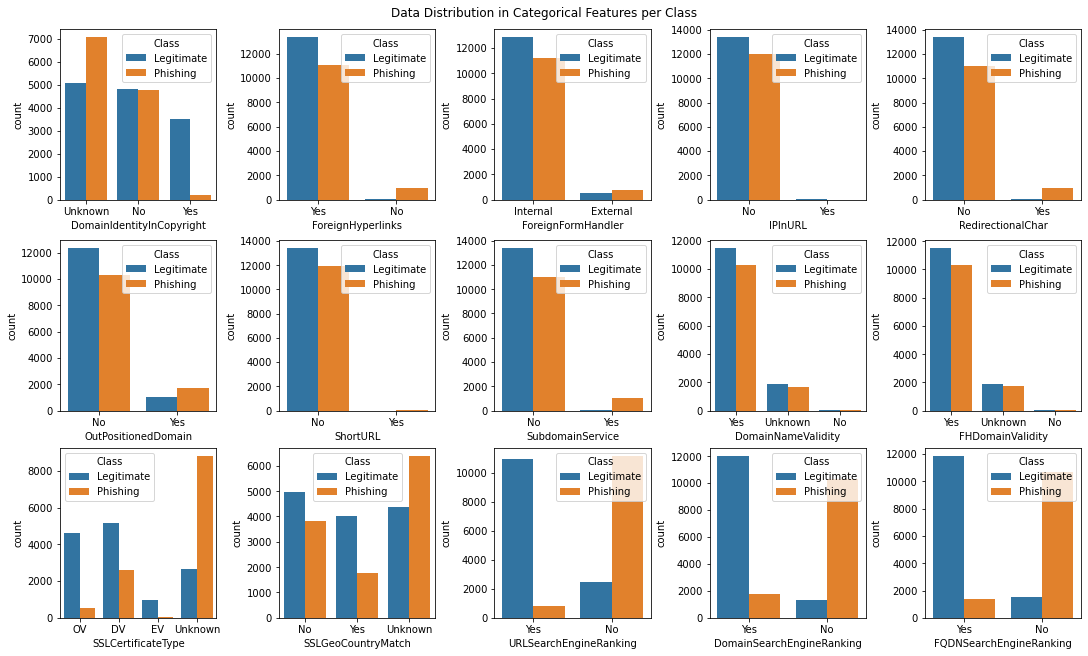

In [158]:
# plotting bar plots of categorical features and the target
categorical_feats = categorical_cols[:-1]  # drop the target column
fig,axes = plt.subplots(3,5,figsize=(15,9),constrained_layout=True)  # numbers of rows and columns of the subplots depend on the number of categ columns
#plt.subplots_adjust(top=.8)
plt.suptitle("Data Distribution in Categorical Features per Class")
axes = axes.flatten()
for col in categorical_feats :
    sns.countplot(df[col], hue=df['Class'], ax=axes[categorical_feats.index(col)])
plt.show()

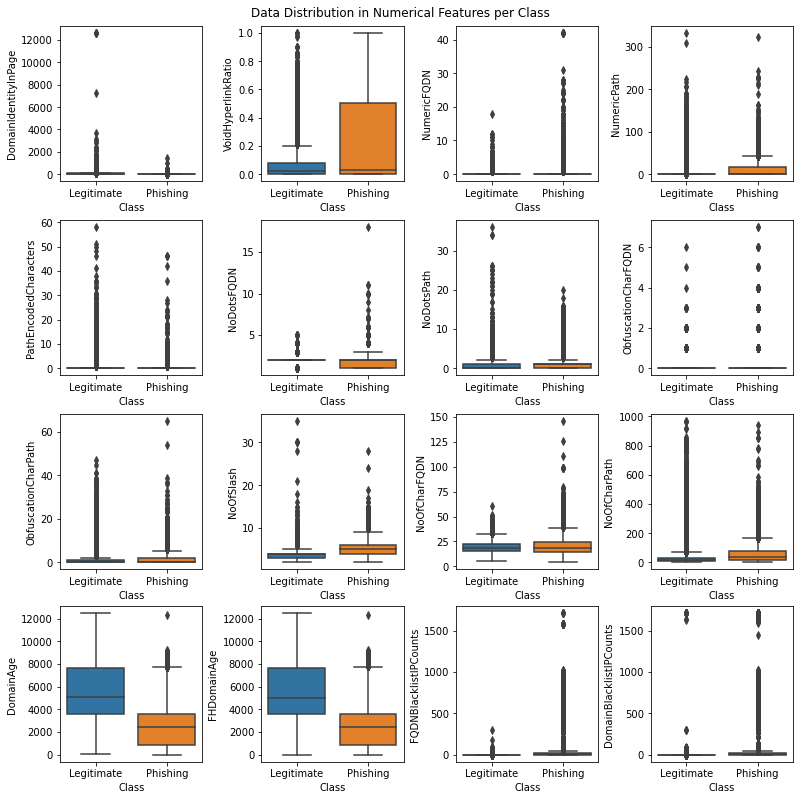

In [159]:
# investigating the distribution of data in the numerical columns per the target column
fig,axes = plt.subplots(4,4, figsize=(11,11), constrained_layout=True, sharex=False)  
plt.suptitle("Data Distribution in Numerical Features per Class")
axes = axes.flatten()
for col in numerical_cols :
    sns.boxplot(x=df['Class'], y=df[col], ax=axes[numerical_cols.index(col)])
plt.show()

Summary of the high level observations:
1. In the first plot, it can be seen that there are fewer pairs with a linear relationship (e.g 'DomainBlacklistCounts' and 'FQDNBlacklistCounts') than those with non-linear or no relationship at all. 
2. The second plot illustrates that there is a largely unequal distribution of data of unique values in most categorical features. However, in most cases, there is less but significant unequal distribution of the values of the same feature between the two classes, suggesting that most features are likely to be important predictors.
3. The third plot shows that there is a significant unequal distribution of feature values per class in most features. The two features 'DomainAge' and 'FHDomainAge' appear to have almost identical distribution, suggesting that they are likely to have the same prediction influence on the task.

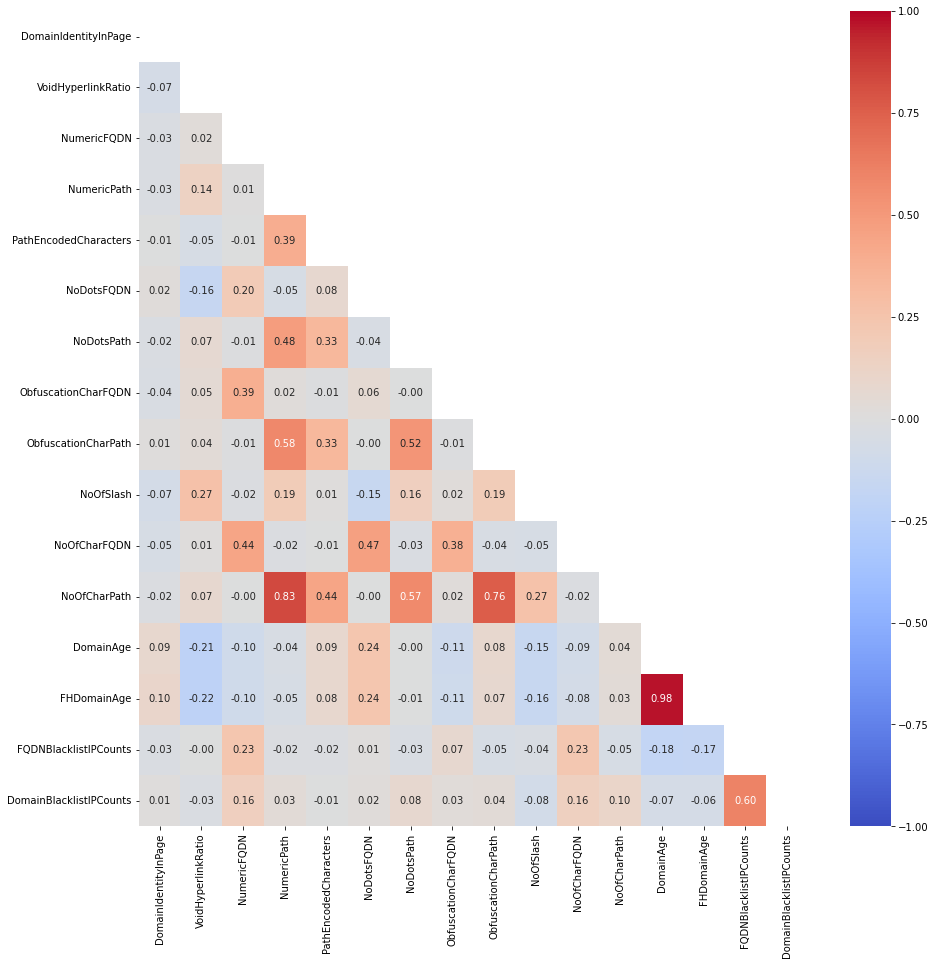

In [160]:
# plotting heatmap of the correlation coefficients of numerical features
plt.figure(figsize=(15,15))
corr_matrix = df.corr()
mask = np.triu(corr_matrix)  # remove diagonal values which are always 1 and the upper triangle which is a duplicate of the lower one
image = sns.heatmap(corr_matrix, annot=True, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask) # annot=show numbers, fmt='.1f'= show 1 number of decimal places

Columns FHDomainAge and DomainAge are observed to have a correlation coefficient of 0.98 which indicates that they almost have the same influence in the prediction, as also observed in the previous step. We therefore drop the former for model simplicity.

In [161]:
df.drop(['FHDomainAge'], axis=1, inplace=True)

## Feature Encoding

Here we convert categorical values into numerical values using label encoding method. All categorical features have nominal values. Given that all the features have low cardinality (few unique values, max being 4), the ideal method would have been one hot encoding. We, however, choose label encoding over one hot encoding so that we can maintain the same original features for performing model explainability analysis (in the last section). In addition, we compared these two methods and observed that the former yielded better prediction results than the latter in most algorithms across most metrics.

In [162]:
# label encoding the target column
encoded_target= ce.OrdinalEncoder(cols=['Class'], return_df=True, mapping=[{'col':'Class','mapping':{'Legitimate':0,'Phishing':1}}])   
df = encoded_target.fit_transform(df)
# Since all the features have low cardinality (few unique values, max being 4) with nominal (unordered values), one hot encoding is applied to each
# label encoding the categorical columns
categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
for col in categorical_cols :
    df[col] = LabelEncoder().fit_transform(df[col])
df.head()

,DomainIdentityInPage,DomainIdentityInCopyright,ForeignHyperlinks,VoidHyperlinkRatio,ForeignFormHandler,IPInURL,NumericFQDN,NumericPath,PathEncodedCharacters,RedirectionalChar,...,DomainAge,FHDomainValidity,SSLCertificateType,SSLGeoCountryMatch,URLSearchEngineRanking,DomainSearchEngineRanking,FQDNSearchEngineRanking,FQDNBlacklistIPCounts,DomainBlacklistIPCounts,Class
0,10.0,1,1,0.00,1,0,1.0,0.0,0.0,0,...,8832.0,2,2,0,1,1,1,0.0,0.0,0
1,13.0,0,1,0.00,1,0,0.0,0.0,0.0,0,...,4984.0,2,2,2,1,1,1,0.0,0.0,0
2,1.0,0,1,0.12,1,0,0.0,0.0,0.0,0,...,1909.0,2,2,2,1,1,1,0.0,0.0,0
3,111.0,2,1,0.07,1,0,0.0,1.0,0.0,0,...,8334.0,2,2,2,0,1,1,0.0,0.0,0
4,103.0,2,1,0.03,1,0,0.0,1.0,0.0,0,...,8334.0,2,2,2,0,1,1,0.0,0.0,0


## Splitting Prediction and Target Variables
We split the dataset into prediction features and a target

In [163]:
df = shuffle(df)
X = df.drop(["Class"], axis=1)
y = df["Class"]
print('Number of features before selection: ', len(X.columns.to_list()))

Number of features before selection:  30


## Feature Selection
We use Recursive Feature Elimination (RFE) with cross validation to automatically identify the best predictive features

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
kf = StratifiedKFold(n_splits=10, random_state=2, shuffle=True)
rfecv = RFECV(estimator=RandomForestClassifier(), min_features_to_select=3, cv=kf, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])
for i in range(X.shape[1]):
    row = {'feature': X.columns[i], 'support': rfecv.support_[i], 'ranking': rfecv.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
df_features.sort_values(by='ranking')
df_features = df_features[df_features['support']==True]  # selected best features always give support value as True
best_features = df_features['feature'].to_list()  # get all values of the column
print("Number features after feature selection : ", len(df_features['feature']))
X = df[best_features]

Number features after feature selection :  23


## Model Evaluation
Various traditional ML algorithms for classification are used to evaluate the dataset in order to compare their performances and identify the best performing algorithms for the task. Several performance metrics are used to report and compare the algorithms

In [165]:
models = []
models_results_list = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('NN', MLPClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=4)))
models.append(('GB', GradientBoostingClassifier(random_state=20)))
models.append(('LGBM', LGBMClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('CatBoost', CatBoostClassifier(logging_level='Silent')))
models.append(('ExtraTrees', ExtraTreesClassifier()))
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
for name, model in models:
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    accurs = []
    precs = []
    recs = []
    f1s = []
    FPRs = []
    FNRs = []
    aucs = []
    for train_index, test_index in rkf.split(X, y):
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = model.score(X_test_scaled, y_test)
        accurs.append(accuracy)
        precision = precision_score(y_test, y_pred)
        precs.append(precision)
        recall = recall_score(y_test, y_pred)
        recs.append(recall)
        f1 = f1_score(y_test, y_pred)
        f1s.append(f1)
        if name == 'SVM' :
            auc = roc_auc_score(y_test, model.decision_function(X_test_scaled))
        else: 
            auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
        aucs.append(auc)
        cm = confusion_matrix(y_test, y_pred)
        TN = TN + cm[0,0]
        TP = TP + cm[1,1]
        FN = FN + cm[1,0]
        FP = FP + cm[0,1]
    FPR = round((FP / (FP + TN))*100,2)
    FNR = round((FN / (FN + TP))*100,2)
    accur_mean = round((np.mean(accurs)*100),2)
    prec_mean = round(np.mean(precs),2)
    recall_mean = round(np.mean(recs),2)
    f1_mean = round(np.mean(f1s),2)
    AUC_mean = round(np.mean(aucs),2)
    df_model_results = pd.DataFrame({"Accuracy(%)":accur_mean, "FPR(%)":FPR, "FNR(%)":FNR, "f1":f1_mean, 'AUC':AUC_mean}, index=[name])
    models_results_list.append(df_model_results)
df_results = pd.concat(models_results_list, axis=0)  # appending dataframes row-wise
df_results.sort_values(['Accuracy(%)', 'FPR(%)', 'FNR(%)'], ascending=[False,True,True])

,Accuracy(%),FPR(%),FNR(%),f1,AUC
CatBoost,98.67,0.89,1.81,0.99,1.00
XGB,98.59,1.06,1.80,0.99,1.00
RF,98.57,1.04,1.87,0.98,1.00
LGBM,98.56,1.06,1.87,0.98,1.00
ExtraTrees,98.20,1.20,2.46,0.98,1.00
GB,97.94,1.38,2.81,0.98,1.00
DT,97.41,2.50,2.68,0.97,0.97
NN,97.12,2.25,3.59,0.97,0.99
SVM,96.24,2.34,5.33,0.96,0.99
KNN,95.76,2.99,5.63,0.95,0.98


## ROC Analysis

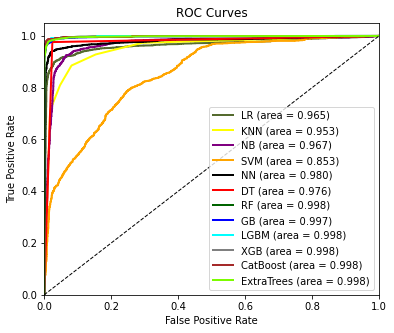

In [166]:
names = []
accurs = []
precs = []
recs = []
f1s = []
aucs = []
fprs = []
tprs = []
roc_aucs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)  # we have a new X that is already standardized
for name, model in models:
    names.append(name)
    model.fit(X_train, y_train)
    if name =='SVM' :  
        y_pred_prob = model.decision_function(X_test)
    else :
        y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,pos_label=1) 
    auc = roc_auc_score(y_test, y_pred_prob)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc)     
colors = ['darkolivegreen','yellow','purple','orange','black','red','darkgreen','blue','cyan','gray','brown','lawngreen']
plt.figure(figsize=(6,5))
for i in range(0, len(names)) :
    plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=names[i] +' (area = %0.3f)' % roc_aucs[i])
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

Comparing performances of the algorithms in the above two sections, XGBoost (XGB) is observed to outperform the rest across most metrics. We therefore tune the algorithm in the next section in search of an optimal performance

## Hyperparameter Tuning


In [167]:
# tuning CatBoost with RandomSearch
warnings.filterwarnings("ignore")
time_start = time.time()
params = { 
    'iterations' : [100, 300, 500, 700, 900, 1100],  # also known as number of estimators
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'depth': [3, 4, 5, 6, 8, 10],
    'l2_leaf_reg': [3, 5, 7, 9],
    'subsample': [i/10.0 for i in range(3,10)], 
        }
xgb = CatBoostClassifier(logging_level='Silent', random_state=123)
kf = StratifiedKFold(n_splits=3) 
grid = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=100, cv=kf, random_state=8, verbose=0, n_jobs=-1)
#grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', n_jobs=-1, cv=kf)
grid.fit(X_train, y_train)
print('Best Parameters:', grid.best_params_)
model = grid.best_estimator_   # get the best model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
TP = TN = FP = FN = 0
TN = TN + cm[0,0]
TP = TP + cm[1,1]
FN = FN + cm[1,0]
FP = FP + cm[0,1]  
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print('Optimal Accuracy :', round((accuracy*100),2),'%', ' | FPR :', round(FPR*100,2),'% | FNR :', round(FNR*100,2),' | f1 :', round(f1,2))
time_end = time.time()
execTime = time_end - time_start 
print('Time :' , round(execTime/3600,2), ' hrs')

Best Parameters: {'subsample': 0.4, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 1100, 'depth': 8}
Optimal Accuracy : 98.76 %  | FPR : 0.94 % | FNR : 1.58  | f1 : 0.99
Time : 0.52  hrs


Using Random search method, best hyperparameters are identified which have improved the performance of the CatBoost algorithm across most of the metrics compared to the default hyperparameters

In [168]:
# tuning CatBoost with GridSearch
warnings.filterwarnings("ignore")
time_start = time.time()
params = { 
    'iterations' : [100, 300, 500, 700, 900, 1100],  # also known as number of estimators
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'depth': [3, 4, 5, 6, 8, 10],
    'l2_leaf_reg': [3, 5, 7, 9],
    'subsample': [i/10.0 for i in range(3,10)], 
        }
xgb = CatBoostClassifier(logging_level='Silent', random_state=123)
kf = StratifiedKFold(n_splits=3) 
#grid = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=100, cv=kf, random_state=8, verbose=0, n_jobs=-1)
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', n_jobs=-1, cv=kf)
grid.fit(X_train, y_train)
print('Best Parameters:', grid.best_params_)
model = grid.best_estimator_   # get the best model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
TP = TN = FP = FN = 0
TN = TN + cm[0,0]
TP = TP + cm[1,1]
FN = FN + cm[1,0]
FP = FP + cm[0,1]  
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print('Optimal Accuracy :', round((accuracy*100),2),'%', ' | FPR :', round(FPR*100,2),'% | FNR :', round(FNR*100,2), ' | f1 :', round(f1,2))
time_end = time.time()
execTime = time_end - time_start 
print('Time :' , round(execTime/3600,2), ' hrs')

Best Parameters: {'depth': 6, 'iterations': 700, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'subsample': 0.4}
Optimal Accuracy : 98.7 %  | FPR : 0.79 % | FNR : 1.87  | f1 : 0.99
Time : 18.38  hrs


## Model Explainability and Feature Importance
Here we analyze how each feature influences the model's prediction output and therefore helps us to understand their importance levels in the task. We analyze this using SHAP values computed by a SHAP package using the best performing algorithm Catboost

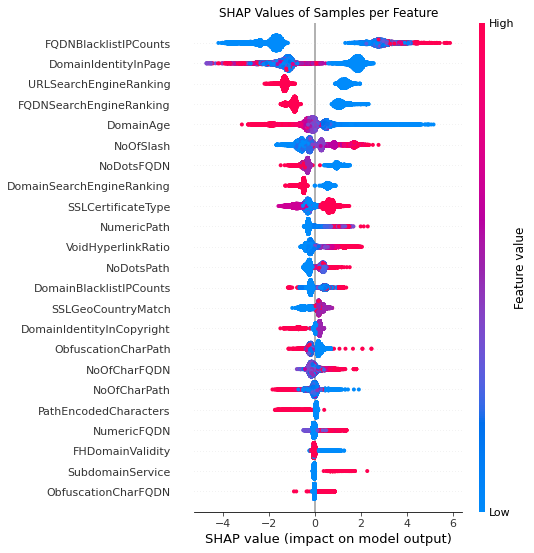

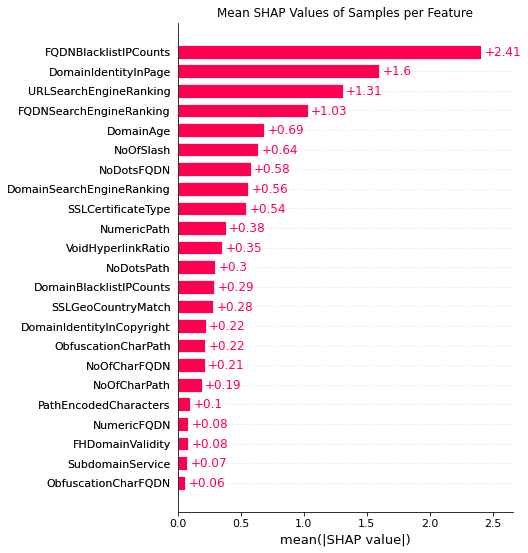

In [169]:
# analysis of feature impact on the prediction using SHAP values
CBR = CatBoostClassifier(logging_level='Silent')
model = CBR.fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
# beeswarm plot
shap.plots.beeswarm(shap_values, max_display=len(X_train), show=False)
plt.title("SHAP Values of Samples per Feature")
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.gcf().set_size_inches(6,9)
plt.show()
print('\n')
# bar plot
shap.plots.bar(shap_values, max_display=len(X_train), show=False)
plt.title("Mean SHAP Values of Samples per Feature")
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.gcf().set_size_inches(6,9)
plt.show()